# Imports

In [ ]:
!pip install umap-learn[plot]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import activations, datasets, layers, losses, metrics, models, optimizers, regularizers
import seaborn as sns
import pandas as pd
import umap

In [3]:
# Ignore warnings from UMAP
import warnings
warnings.filterwarnings('ignore')

# Datasets

In [100]:
(xTrain, yTrain),(xTest, yTest) = datasets.cifar100.load_data()
xTrain = xTrain / 255.
xTest  = xTest  / 255.

xTrainPad  = np.pad(xTrain.reshape(-1, 320, 320, 3), ((0,0),(0,0),(0,0),(0,0)), 'constant')
xTestPad   = np.pad(xTest.reshape(-1, 320, 320, 3), ((0,0),(0,0),(0,0),(0,0)), 'constant')

# Experiments

In [6]:
!pip install -U vit-keras
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [53]:
IMAGE_SIZE = 32
BATCH_SIZE = 16
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
NUM_CLASSES = 100

In [47]:
import keras 
import tensorflow as tf

LOSS = tf.keras.losses.BinaryCrossentropy() # Not un-weighted 
METRICS = [
      keras.metrics.CategoricalAccuracy(name="accuracy"),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [88]:
# build vit model with 16 patch_size
from vit_keras import vit
import tensorflow as tf
import typing_extensions as tx

classes = vit.validate_pretrained_top(
    include_top=True,
    pretrained=True,
    classes=NUM_CLASSES,
    weights="imagenet21k+imagenet2012",
)

model_vit = vit.build_model(
        dropout = 0.1,
        mlp_dim = 3072,
        num_heads = 12,
        num_layers = 12,
        hidden_size = 768,
        name = "vit-b32",
        patch_size = 32,
        image_size = (320,320),
        classes = classes,
        activation = 'softmax',
        include_top = False)

# base_model.trainable = True

# x = base_model.output
# predictions = tf.keras.layers.Dense(NUM_CLASSES, activation = 'sigmoid', name = 'Final')(x)
# model_vit = tf.keras.models.Model(name = "vit_b32", inputs = base_model.input, outputs = predictions)

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_vit.compile(loss = 'binary_crossentropy', optimizer = OPTIMIZER, metrics = METRICS)

In [89]:
model_vit.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 320, 320, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 10, 10, 768)       2360064   
                                                                 
 reshape_24 (Reshape)        (None, 100, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 101, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 101, 768)         77568     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 101, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [90]:
Y_pred = model_vit.predict(xTestPad)

In [95]:
reducer = umap.UMAP(n_components=3)
embeddingUmap = reducer.fit_transform(Y_pred)

In [96]:
import matplotlib.pyplot as plt
import numpy as np

def print2D(embedding, title):
  plt.figure(figsize=[25,10])
  plt.scatter(
      embedding[:, 0],
      embedding[:, 1])
  plt.gca().set_aspect('equal', 'datalim')
  plt.title(title, fontsize=24)
  plt.show()

def print3D(embedding, title, classes):
  fig = plt.figure(figsize=[25,10])
  ax = plt.axes(projection ="3d")
  p = ax.scatter(
      embedding[:, 0],
      embedding[:, 1],
      embedding[:, 2],
      c = classes
  )
  plt.title(title, fontsize=24)
  fig.colorbar(p,boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
  plt.show()

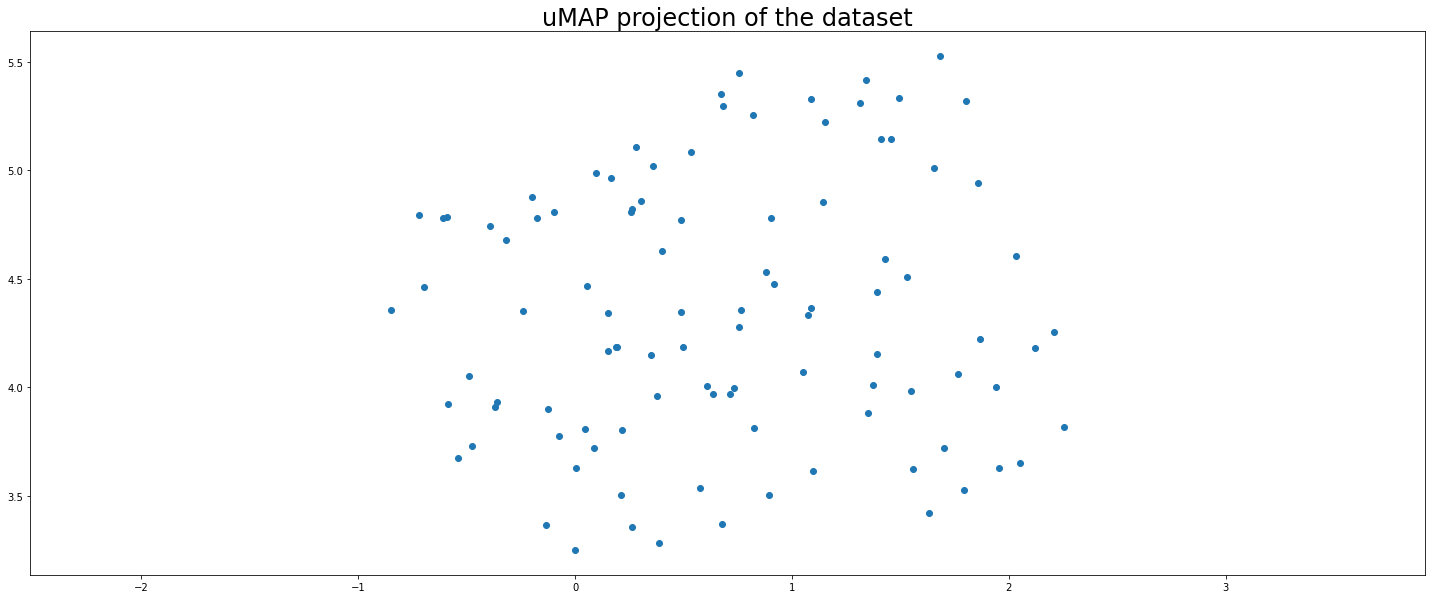

In [97]:
print2D(embeddingUmap, "uMAP projection of the dataset")

ValueError: ignored

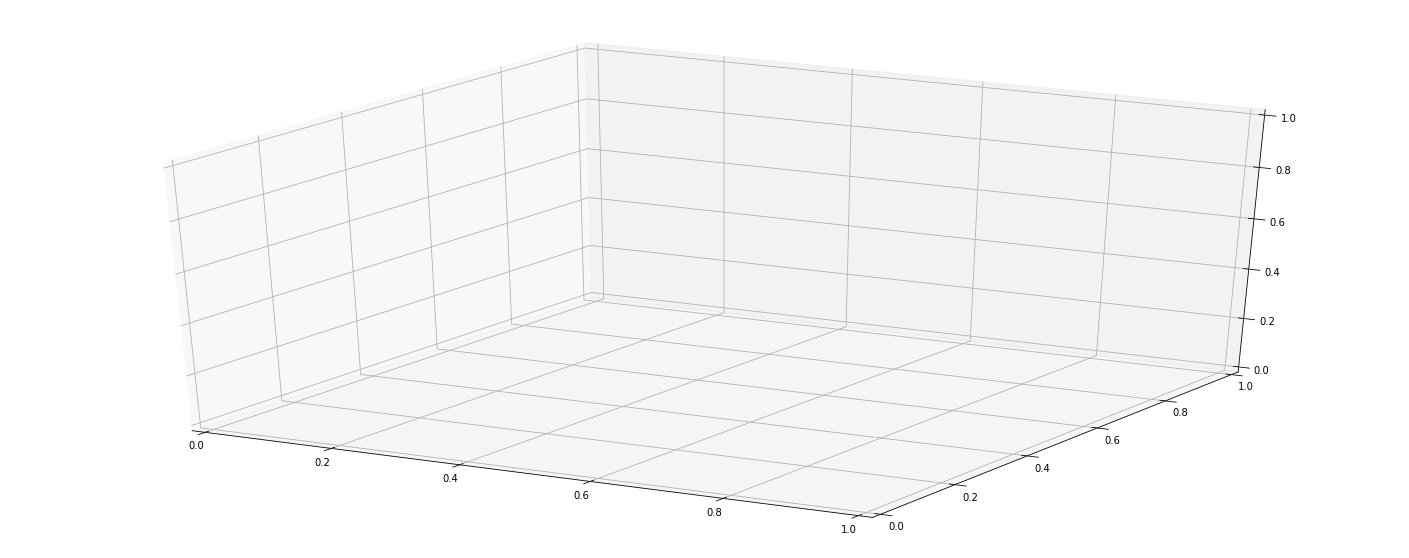

In [101]:
print3D(embeddingUmap, "uMAP projection of the dataset", xTestPad) 